In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
cmap = cc.cm.blues
import scipy
%matplotlib inline
%config Completer.use_jedi = False
import os
savepath = '../figs/'
try:
    os.chdir('digits_summaries')
except:
    os.chdir('../digits_summaries')

**Joint-training using CNNs on digits dataset**

Creates some example plots for joint-training with a single (true,hypothesized) task pair that were not shown in the paper.

In [14]:
D = np.load('results_headlr_med_pen=cross_rc_thresh_hard.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']  #(task,resp,frac_correct)
sparsities = D['sparsities']
alphas=D['alphas']
cms = D['cms']
l1s=D['l1s']
alignments=D['alignments']
trials=train_losses.shape[0]
print(test_losses.shape) #trials, alpha, lambda, losses


(40, 12, 9, 3)


[9.9999e-01 9.9990e-01 9.9900e-01 9.9000e-01 9.5000e-01 9.0000e-01
 8.5000e-01 7.5000e-01 5.0000e-01 1.0000e-03 1.0000e-04 1.0000e-05]


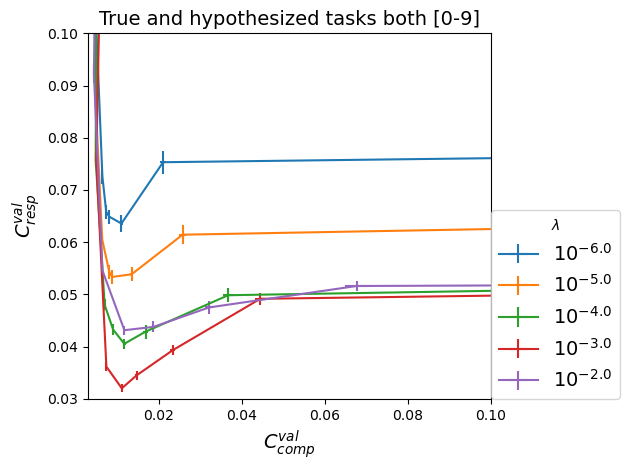

In [91]:

fig,ax = plt.subplots()

# order = [0,2,3,4,5,6,1]
alphas=np.array(alphas)
order = np.arange(alphas.size)[:]
print(alphas)
L_task = np.nanmean(test_losses[:,:,:,0],axis=0)[order,:]
L_resp = np.nanmean(test_losses[:,:,:,1],axis=0)[order,:]
e_task = np.nanstd(test_losses[:,:,:,0],axis=0)[order,:]/np.sqrt(trials)
e_resp = np.nanstd(test_losses[:,:,:,1],axis=0)[order,:]/np.sqrt(trials)
show_lis = np.arange(0,l1s.size,2)

for li in show_lis:
    plt.errorbar(L_task[:,li],L_resp[:,li],xerr=e_task[:,li],yerr=e_resp[:,li])
plt.legend(['$10^{{{}}}$'.format(i) for i in np.log10(l1s[show_lis])],loc=(1,0),title='$\lambda$',fontsize=14)


plt.xlabel('$C^{val}_{comp}$',fontsize=14)
plt.ylabel('$C^{val}_{resp}$',fontsize=14)
plt.title('True and hypothesized tasks both [0-9]',fontsize=14)

plt.xlim([0.003,0.1])
plt.ylim([0.03,0.1])

fig.tight_layout()
plt.savefig(savepath+'digits_teacher_curves_example')


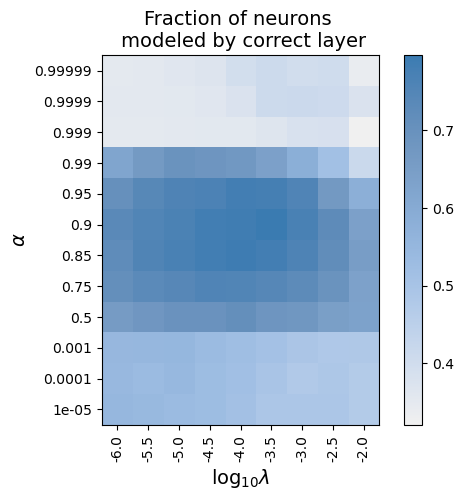

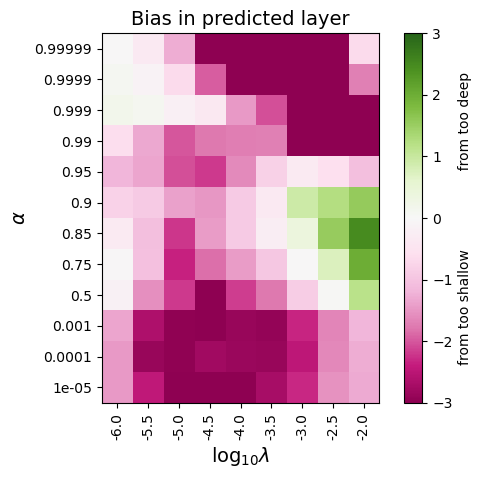

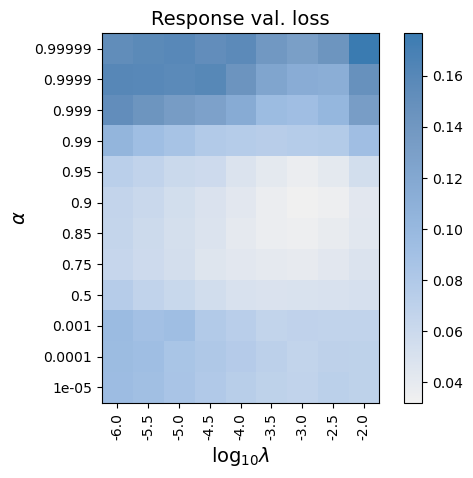

In [152]:
from_too_deep = (cms[:,:,:,0,1]+cms[:,:,:,0,2]+cms[:,:,:,1,2])/np.sum(cms,axis=(-2,-1))
from_too_shallow = (cms[:,:,:,1,0]+cms[:,:,:,2,0]+cms[:,:,:,2,1])/np.sum(cms,axis=(-2,-1))
just_right = (cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])/np.sum(cms,axis=(-2,-1))

plt.imshow(np.nanmean(just_right,axis=0),cmap=cmap)
# plt.imshow(np.std(just_right,axis=0))
plt.title('Fraction of neurons \n modeled by correct layer',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar()

fig,ax = plt.subplots()
# plt.imshow(np.mean(from_too_deep-from_too_shallow,axis=0),vmin=-0.2,vmax=0.2,cmap='PiYG')
plt.imshow(np.nanmean(from_too_deep-from_too_shallow,axis=0)/np.nanstd(from_too_deep-from_too_shallow,axis=0),vmin=-3,vmax=3,cmap='PiYG')

plt.title('Bias in predicted layer',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar(label='from too shallow                  from too deep')


fig,ax = plt.subplots()
plt.imshow(np.nanmean(test_losses[:,:,:,1],axis=0),cmap=cmap)

plt.title('Response val. loss',fontsize=14)
plt.xticks(np.arange(l1s.size),np.round(np.log10(l1s),1),rotation=90)
plt.xlabel('$\\log_{10}\\lambda$',fontsize=14)
plt.yticks(np.arange(alphas.size),alphas)
plt.ylabel('$\\alpha$',fontsize=14)
plt.colorbar()


Creates Figure 4B, S3 C and D, and another not included

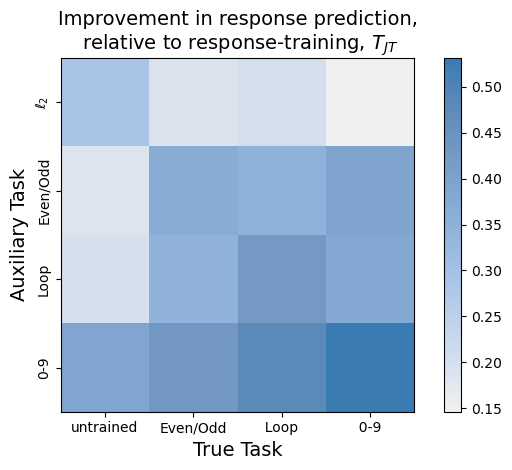

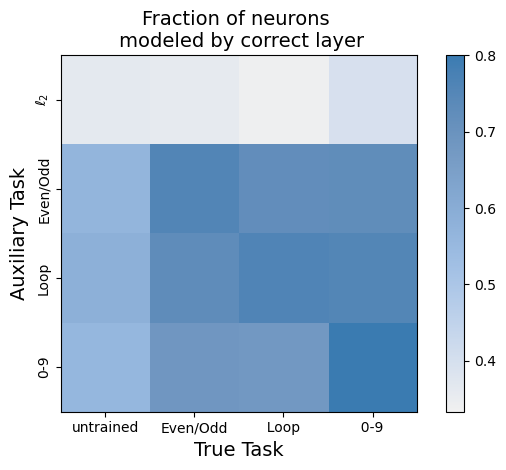

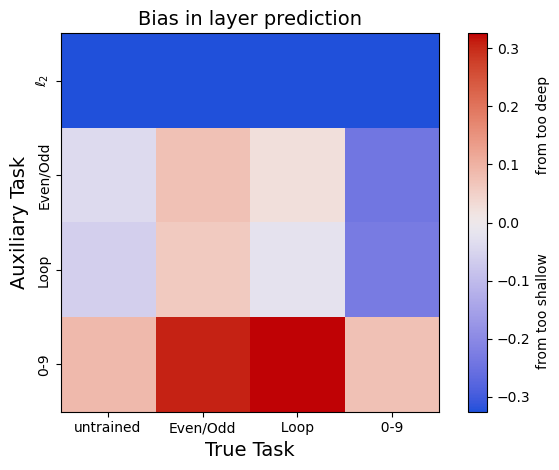

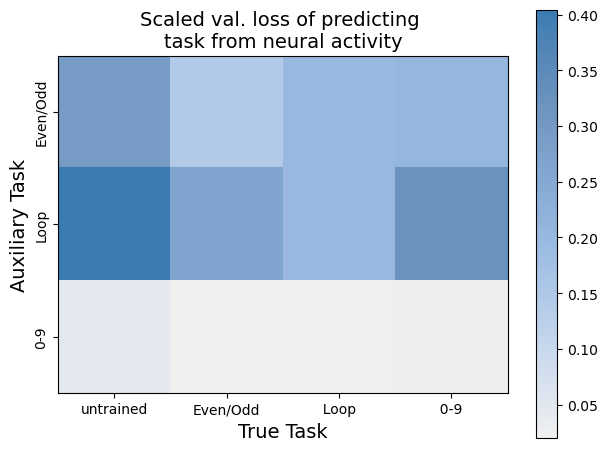

In [29]:
order = [0,1,2,3]
trials = 40
task_dims = [1,2,2,10]
if False:
    penstr = ''
    pen_label = '_noreg'
    thresh = False
else:
    penstr = '_pen=cross_rc'
    pen_label = ''
    thresh = True
    
joint = True


matchstrs = [['_L2matched','_eomatched','_loopmatched',''][i] for i in order]
trainstrs = [['_untrained', '_eotrained','_looptrained',''][i] for i in order]
hypo_labels = [['$\ell_2$','Even/Odd','Loop','0-9'][i] for i in order]
train_labels = [['untrained','Even/Odd','  Loop  ','  0-9  '][i] for i in order]


layer_acc = np.zeros((len(matchstrs),len(trainstrs)))
layer_bias = np.zeros((len(matchstrs),len(trainstrs)))
teaches = np.zeros((trials,len(matchstrs),len(trainstrs)))
SdP = 6*8/1023
d = [16,32,128,10]
shapes = np.array([[d[0]*24, d[1]*10,d[2]]])
rs = 1/np.sqrt(shapes.T.dot(shapes)) #renormalization for W_ij


all_Ls = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))
all_fracs = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))
all_biass = np.nan*np.ones((trials,len(matchstrs),len(trainstrs),20,20))

task_matches = np.zeros((trials,len(matchstrs)-1,len(trainstrs)))

for m_i, match in enumerate(matchstrs):
    for t_i, train in enumerate(trainstrs):
        fname = 'results_headlr_med'+train+match+penstr+'_thresh_hard'*thresh+'.npz'

        D = np.load(fname)
        alpha_min, lambda_min = np.unravel_index(np.argmin(np.mean(D['test_losses'][:,:,:,1],axis=0)),(D['alphas'].size,D['l1s'].size))
        if not joint:
            alpha_min = 0
        
        bls = np.mean(D['test_losses'][:,-1,lambda_min,1])
        if m_i>0:
            a = D['task_alignments'][:,alpha_min,lambda_min,1,m_i-1,:]
            task_matches[:,m_i-1,t_i] = np.min(a[np.isfinite(a)],axis=-1)/task_dims[m_i]

        
        teaches[:,m_i,t_i] = (bls-D['test_losses'][:,alpha_min,lambda_min,1])/bls
#         if joint:
#             teaches[:,m_i,t_i] /= task_dims[m_i]
#         else:
#             teaches[:,m_i,t_i] = (teaches[:,m_i,t_i] - SdP)/task_dims[m_i]
        
        cms = D['cms']
        cms*= np.reshape(rs,(1,1,1,3,3)) #change normalization of W_ij to match what is in the paper
        bias_denom = np.sum(cms,axis=(-2,-1))-(cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])
        from_too_deep = (cms[:,:,:,0,1]+cms[:,:,:,0,2]+cms[:,:,:,1,2])/bias_denom
        from_too_shallow = (cms[:,:,:,1,0]+cms[:,:,:,2,0]+cms[:,:,:,2,1])/bias_denom
        just_right = (cms[:,:,:,0,0]+cms[:,:,:,1,1]+cms[:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
        layer_acc[m_i,t_i] = np.mean(just_right,axis=0)[alpha_min,lambda_min]
        lbs = (from_too_deep-from_too_shallow)#/(np.std(from_too_deep-from_too_shallow,axis=0)/np.sqrt(trials))
        layer_bias[m_i,t_i] = np.mean(lbs,axis=0)[alpha_min,lambda_min]
        
        all_biass[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = lbs
        all_fracs[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = just_right
        all_Ls[:,m_i,t_i,:D['alphas'].size,:D['l1s'].size] = (bls-D['test_losses'][:,:,:,1])/bls

fnames = ['Tjt','frac_correct','bias','zfromy_loss']
titles = ['Improvement in response prediction,\n relative to response-training, '+('$T_{JT}$' if joint else '$T_{TT}$'),'Fraction of neurons \n modeled by correct layer','Bias in layer prediction','Scaled val. loss of predicting \ntask from neural activity']
data = [np.mean(teaches,axis=0),layer_acc,layer_bias,np.mean(-task_matches,axis=0)/np.sqrt(np.expand_dims(task_dims[1:],-1))]

cmaps = [cmap,cmap,cc.cm.coolwarm,cmap]
vmins = [None,1/3,'sym',None]
vmaxs = [None,0.8,'sym',None]
 
for i in range(len(titles)):
    fig,ax = plt.subplots()
    vmin = vmins[i] if vmins[i]!='sym' else -np.max(data[i])
    vmax = vmaxs[i] if vmaxs[i]!='sym' else np.max(data[i])
    
    plt.imshow(data[i],cmap=cmaps[i],vmin=vmin,vmax=vmax)
    plt.colorbar(label='from too shallow                  from too deep' if i==2 else None)
    plt.title(titles[i],fontsize=14)
    plt.yticks(np.arange(len(hypo_labels)-(i==3)),hypo_labels[int(i==3):],rotation=90,verticalalignment='center')
    plt.ylabel('Auxiliary Task',fontsize=14)
    plt.xticks(np.arange(len(train_labels)),train_labels)
    plt.xlabel('True Task',fontsize=14)
    fig.tight_layout()
    plt.savefig(savepath+'digits_'+fnames[i]+pen_label+'_TT'*(not joint))

                




Creates Figure 4A

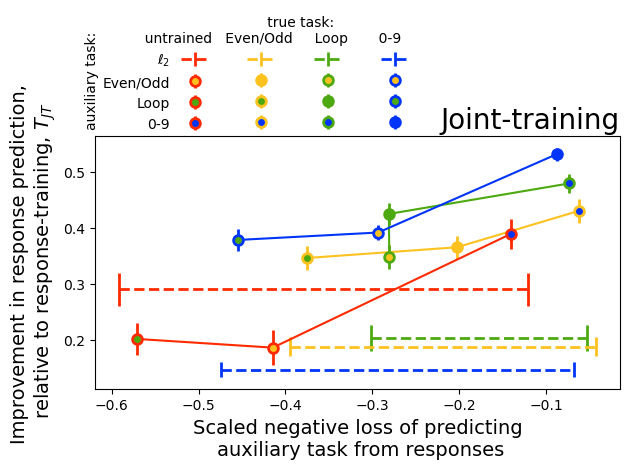

In [30]:
fig,ax = plt.subplots()
cmap2 = cc.cm.rainbow
cs = np.flipud(cmap2(np.arange(4)/3))
# cs = ['m','r','g','b']
_, matchs, trains = task_matches.shape


hs = np.empty((trains, matchs+1),dtype=object)

for t_i in range(trains):
    h = plt.errorbar([np.min(task_matches[:,:,t_i])-0.02,np.max(task_matches[:,:,t_i])+0.02],[np.mean(teaches,axis=0)[0,t_i]]*2,yerr=np.std(teaches[:,0,t_i])/np.sqrt(trials),ls='--',lw=2,c=cs[t_i],zorder=-t_i)
    hs[t_i,0] = h

for t_i in range(trains):
    for m_i in range(matchs):   
        h = plt.errorbar(np.mean(task_matches[:,m_i,t_i]),np.mean(teaches[:,m_i+1,t_i]),yerr=np.std(teaches[:,m_i+1,t_i])/np.sqrt(trials),fmt='o'
                         ,markerfacecolor=cs[m_i+1],ecolor=cs[t_i],markeredgecolor=cs[t_i],markeredgewidth=2,elinewidth=2,ms=7)
        hs[t_i,m_i+1] = h
for t_i in range(trains):
    order = np.argsort(-np.mean(task_matches[:,:,t_i]+teaches[:,1:,t_i],axis=0))
    plt.plot(np.mean(task_matches[:,:,t_i],axis=0)[order],np.mean(teaches[:,1:,t_i],axis=0)[order],color=cs[t_i])

matchs+=1
labels = hypo_labels[-matchs:]+['']*(matchs-1)*(trains+1)
title = ' '*38+'true task:\n'+' '*10+(' '*3).join(train_labels[-trains:])
plt.legend(np.ravel(hs),labels,ncol=trains,markerfirst=False,title=title,loc=(0,1),frameon=False)
b,t = plt.ylim()
l,r = plt.xlim()
plt.text(l-0.02*(r-l),t+0.04*(t-b),'auxiliary task:',rotation=90)

plt.xlabel('Scaled negative loss of predicting\n auxiliary task from responses',fontsize=14)
plt.ylabel('Improvement in response prediction,\n relative to response-training, '+('$T_{JT}$' if joint else '$T_{TT}$'),fontsize=14)
plt.title(('Joint-' if joint else 'Task-')+'training',fontsize=20,loc='right')
fig.tight_layout()
plt.savefig(savepath+'digits_Tjt_vs_zfromy_loss'+pen_label+'_TT'*(not joint))
# plt.ylim([0.05,0.22])


Creates Figure S3 A and B

/var/folders/tk/s873tyxs4_5cv2z4fjgnbwsc0000gn/T/ipykernel_4444/4084556475.py:21: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(M/np.sum(M,axis=0,keepdims=True),cmap=cmap,origin='lower',extent=[xe[0],xe[-1],ye[0],ye[-1]],aspect=(xe[0]-xe[-1])/(ye[0]-ye[-1]))


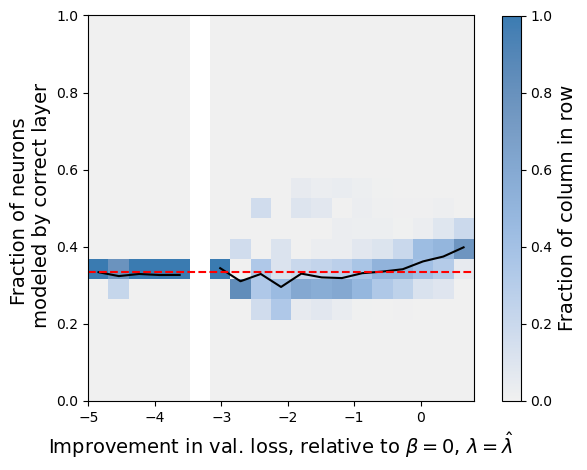

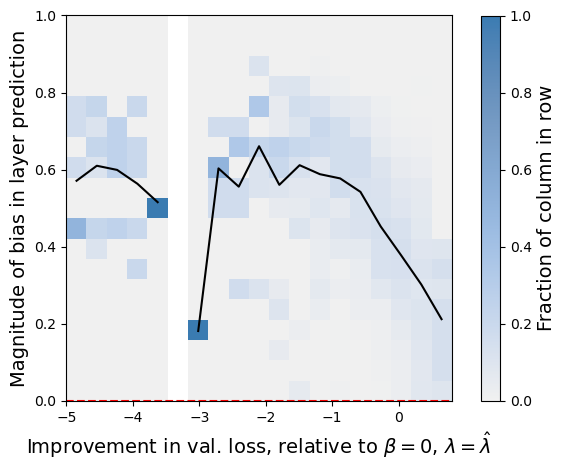

In [119]:
ys = [all_fracs, np.abs(all_biass)]
ylabels = ['Fraction of neurons \n modeled by correct layer','Magnitude of bias in layer prediction']
fnames = ['frac_correct','bias']

for i in range(2):
    x = all_Ls
    y = ys[i]
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    fig,ax = plt.subplots()
    bins = 20
#     bins = [np.hstack((-np.logspace(7,-1,17),[0,0.2,0.4])),np.linspace(0,1,20)]
    bins = [np.linspace(-5,0.8,20),np.linspace(0,1,20)] 
    M,xe,ye = np.histogram2d(x,y,bins=bins)
    M=M.T
    my = np.zeros(xe.size-1)
    for b in range(xe.size-1):
        my[b] = np.mean(y[(xe[b]<x) & (x<xe[b+1])])
    xcs = (xe[:-1]+xe[1:])/2
    plt.imshow(M/np.sum(M,axis=0,keepdims=True),cmap=cmap,origin='lower',extent=[xe[0],xe[-1],ye[0],ye[-1]],aspect=(xe[0]-xe[-1])/(ye[0]-ye[-1]))
    plt.plot(xcs,my,'k')
    plt.plot([xe[0],xe[-1]],[1/3 if i==0 else 0]*2,'r--')
    
    plt.plot()
#     plt.xscale('log')
    plt.ylabel(ylabels[i],fontsize=14)
    plt.xlabel(r'Improvement in val. loss, relative to $\beta=0$, $\lambda=\hat\lambda$',fontsize=14)
    clb = plt.colorbar()
    clb.set_label('Fraction of column in row',fontsize=14)
    fig.tight_layout()
    plt.savefig(savepath+'digits_'+fnames[i]+'_vs_ri'+pen_label)


Text(0.5, 1.0, 'True and hypothesized tasks = [0-9] \n with thresholding')

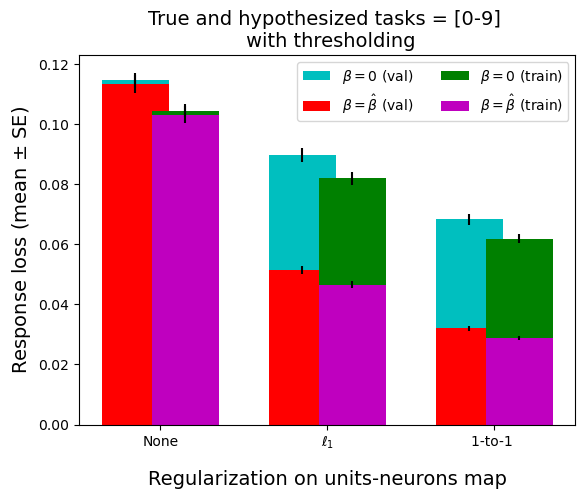

In [341]:
penstrs = ['','_pen=l1','_pen=cross_rc' ]
labels = ['None', '$\ell_1$', '1-to-1 \n']
thresh = True

for i,penstr in enumerate(penstrs):
    fname = 'results_headlr_med'+penstr+'_thresh_hard'*thresh+'.npz'

    D = np.load(fname)
    alpha_min, lambda_min = np.unravel_index(np.argmin(np.mean(D['test_losses'][:,:,:,1],axis=0)),(D['alphas'].size,D['l1s'].size))
#     lambda_min = 0
    
    loss = D['test_losses'][:,:,lambda_min,1]
    bls = loss[:,-1]
#     teaches = (bls-loss[:,alpha_min])/bls
    teaches = loss[:,alpha_min]
    train_loss0 = D['train_losses'][:,-1,lambda_min]
    train_lossb = D['train_losses'][:,alpha_min,lambda_min]

    w = 0.4
    s = 0.15
    plt.bar([i-s],[np.mean(bls)],yerr=np.std(bls)/np.sqrt(teaches.size),ecolor='k',color='c',width=w)
    plt.bar([i-s],[np.mean(teaches)],yerr=np.std(teaches)/np.sqrt(teaches.size),color='r',ecolor='k',width=w)
    plt.bar([i+s],[np.mean(train_loss0)],yerr=np.std(train_loss0)/np.sqrt(teaches.size),ecolor='k',color='g',width=w)
    plt.bar([i+s],[np.mean(train_lossb)],yerr=np.std(train_lossb)/np.sqrt(teaches.size),ecolor='k',color='m',width=w)
    
# plt.ylim([0,0.075])
# plt.grid()
plt.xticks(np.arange(len(labels)),labels)
plt.xlabel('Regularization on units-neurons map',fontsize=14)
plt.ylabel('Response loss (mean $\pm$ SE)',fontsize=14)
plt.legend([r'$\beta=0$ (val)',r'$\beta=\hat\beta$ (val)',r'$\beta=0$ (train)',r'$\beta=\hat\beta$ (train)'],ncol=2)
plt.title('True and hypothesized tasks = [0-9] \n with'+'out'*(not thresh)+' thresholding',fontsize=14)


Creates Figure S4 A and B

In [ ]:
def argmin_except(M,axis):
    ds = len(M.shape)
    return tuple([np.argmin(np.min(M,axis=tuple([d2 for d2 in range(ds) if d2!=axis and d2!=d])),axis=0 if d<axis else 1) if d!=axis else np.arange(M.shape[d]) for d in range(ds)])


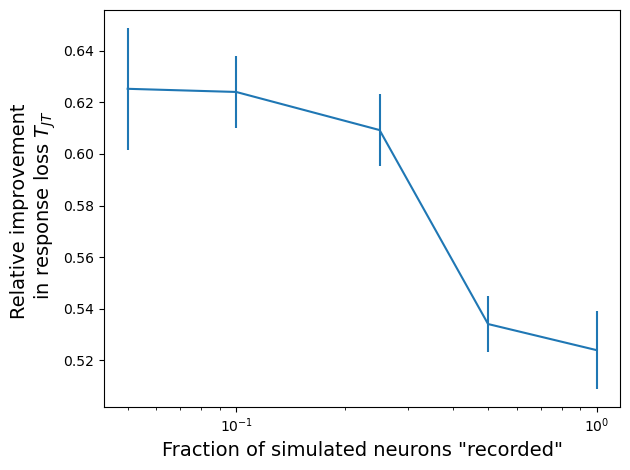

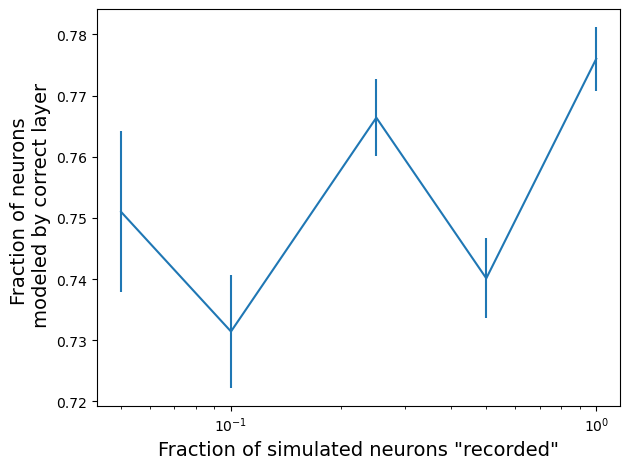

In [111]:

D = np.load('results_headlr_med_pen=cross_rc_thresh_hard_subsets.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']
sparsities=D['cpfns']
cms = D['cms']
d = [16,32,128,10]
shapes = [d[0]*24, d[1]*10,d[2]]
rs = np.tile(np.sqrt(shapes),3)
cms*= np.reshape(rs/rs.T,(1,1,1,3,3))
alignments=D['alignments']
alphas=D['alphas']
subsets = D['subsets']
l1s=D['l1s']

trials=train_losses.shape[0]

rlm = np.mean(test_losses[:,:,:,:,1],axis=0)
rlsem = np.std(test_losses[:,:,:,:,1],axis=0)/np.sqrt(trials)
baseline = np.min(rlm[-3:-1,:,:],axis=(0,1))
best = np.min(rlm,axis=(0,1))
teacherness = (baseline-best)/baseline

fig,ax = plt.subplots()
plt.errorbar(subsets,teacherness,yerr=rlsem[rlm==best]/baseline)
plt.xscale('log')
plt.xlabel('Fraction of simulated neurons \"recorded\"',fontsize=14)
plt.ylabel('Relative improvement \n in response loss $T_{JT}$',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_TJT_vs_subsamp')

fig,ax = plt.subplots()
just_right = (cms[:,:,:,:,0,0]+cms[:,:,:,:,1,1]+cms[:,:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
inds = argmin_except(rlm,2)
sems = np.std(just_right,axis=0)[inds]/np.sqrt(trials)
just_right = np.mean(just_right,axis=0)[inds]
plt.errorbar(subsets,just_right,yerr=sems)
plt.xscale('log')
plt.xlabel('Fraction of simulated neurons \"recorded\"',fontsize=14)
plt.ylabel('Fraction of neurons \n modeled by correct layer',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_layeracc_vs_subsamp')


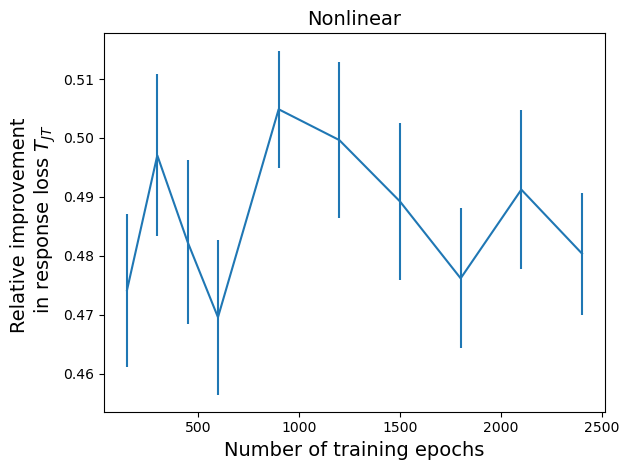

In [114]:
D = np.load('results_headlr_med_pen=cross_rc_epochs.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']
sparsities=D['cpfns']
cms = D['cms']
d = [16,32,128,10]
shapes = [d[0]*24, d[1]*10,d[2]]
rs = np.tile(np.sqrt(shapes),3)
cms*= np.reshape(rs/rs.T,(1,1,1,3,3))
alignments=D['alignments']
alphas=D['alphas']
epochs = D['epochs']
l1s=D['l1s']

trials=train_losses.shape[0]

rlm = np.mean(test_losses[:,:,:,:,1],axis=0)
rlsem = np.std(test_losses[:,:,:,:,1],axis=0)/np.sqrt(trials)
baseline = np.min(rlm[-3:-1,:,:],axis=(0,1))
best = np.min(rlm,axis=(0,1))
teacherness = (baseline-best)/baseline

fig,ax = plt.subplots()
plt.errorbar(epochs,teacherness,yerr=rlsem[rlm==best]/baseline)
plt.xlabel('Number of training epochs',fontsize=14)
plt.ylabel('Relative improvement \n in response loss $T_{JT}$',fontsize=14)
plt.title('Nonlinear',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_TJT_vs_epochs')

# fig,ax = plt.subplots()
# just_right = (cms[:,:,:,:,0,0]+cms[:,:,:,:,1,1]+cms[:,:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
# inds = argmin_except(rlm,2)
# sems = np.std(just_right,axis=0)[inds]/np.sqrt(trials)
# just_right = np.mean(just_right,axis=0)[inds]
# plt.errorbar(epochs,just_right,yerr=sems)
# plt.xlabel('Number of training epochs',fontsize=14)
# plt.ylabel('Fraction of neurons \n modeled by correct layer',fontsize=14)
# plt.title('Nonlinear',fontsize=14)
# fig.tight_layout()
# plt.savefig(savepath+'digits_layeracc_vs_epochs')


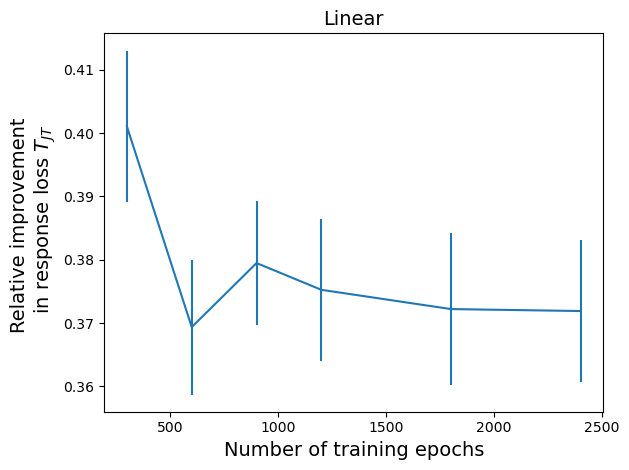

In [120]:
D = np.load('results_headlr_med_pen=cross_rc_epochs_linear.npz')
d = D['d']
in_shape = np.array([8,6])    
N = int(d[0]*np.prod(in_shape-2)+d[1]*np.prod((in_shape-4))+d[1]*np.prod((in_shape-4)/2)+d[2])
train_losses=D['train_losses']
test_losses=D['test_losses']
sparsities=D['cpfns']
cms = D['cms']
d = [16,32,128,10]
shapes = [d[0]*24, d[1]*10,d[2]]
rs = np.tile(np.sqrt(shapes),3)
cms*= np.reshape(rs/rs.T,(1,1,1,3,3))
alignments=D['alignments']
alphas=D['alphas']
epochs = D['epochs']
l1s=D['l1s']

trials=train_losses.shape[0]

rlm = np.mean(test_losses[:,:,:,:,1],axis=0)
rlsem = np.std(test_losses[:,:,:,:,1],axis=0)/np.sqrt(trials)
baseline = np.min(rlm[-3:-1,:,:],axis=(0,1))
best = np.min(rlm,axis=(0,1))
teacherness = (baseline-best)/baseline

fig,ax = plt.subplots()
plt.errorbar(epochs,teacherness,yerr=rlsem[rlm==best]/baseline)
plt.xlabel('Number of training epochs',fontsize=14)
plt.ylabel('Relative improvement \n in response loss $T_{JT}$',fontsize=14)
plt.title('Linear',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'digits_TJT_vs_epochs')

# fig,ax = plt.subplots()
# just_right = (cms[:,:,:,:,0,0]+cms[:,:,:,:,1,1]+cms[:,:,:,:,2,2])/np.sum(cms,axis=(-2,-1))
# inds = argmin_except(rlm,2)
# sems = np.std(just_right,axis=0)[inds]/np.sqrt(trials)
# just_right = np.mean(just_right,axis=0)[inds]
# plt.errorbar(epochs,just_right,yerr=sems)
# plt.xlabel('Number of training epochs',fontsize=14)
# plt.ylabel('Fraction of neurons \n modeled by correct layer',fontsize=14)
# plt.title('Linear',fontsize=14)
# fig.tight_layout()
# plt.savefig(savepath+'digits_layeracc_vs_epochs')


Text(0.5, 1.0, '0')

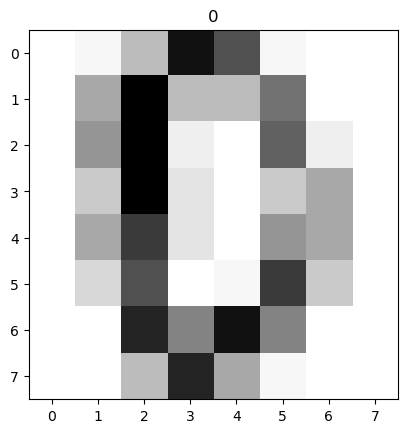

In [843]:
import pandas as pd
D = pd.read_csv('../optical+recognition+of+handwritten+digits/optdigits.tra',header=None)
images = D.values[:,:-1]
images = images.reshape([images.shape[0],8,8])
labels = D.values[:,-1]
i = 0
plt.imshow(images[i,:,:],cmap='Greys')
plt.title(labels[i])

**2-Layer-Linear Theory**

In [247]:
os.chdir('../2LL_summaries')

Extra figures not shown in the paper, same data as Figure S1, showing only T_JT

[[1.31567243e-04 1.31567243e-04 1.31567243e-04]
 [1.39267563e-04 5.45692919e-05 5.45692919e-05]
 [1.61483984e-04 1.09100101e-04 2.26263820e-05]]
[[0.01056782 0.01056782 0.01056782]
 [0.01068608 0.01675785 0.01675785]
 [0.01259494 0.01198237 0.01832834]] (3, 3, 30)
[[4.04602548e-04 4.04602548e-04 4.04602548e-04]
 [2.35179965e-04 1.41860912e-04 1.41860912e-04]
 [1.82737998e-04 1.06158200e-04 9.55385353e-05]]
[[0.00977336 0.00977336 0.00977336]
 [0.00568304 0.01953326 0.01953326]
 [0.00810713 0.0081175  0.02623268]] (3, 3, 30)


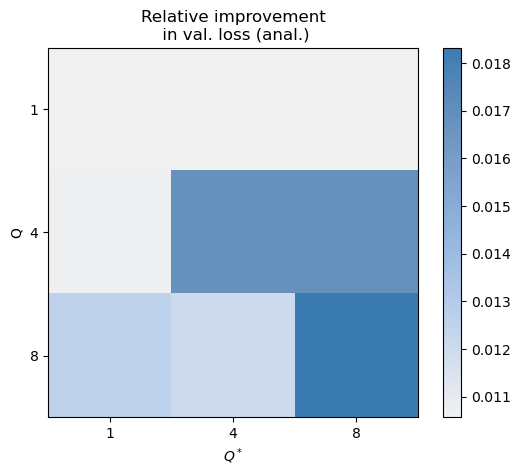

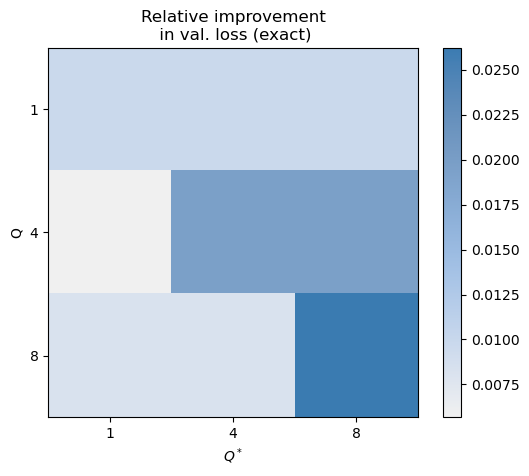

In [67]:
Ns = [5,10]
Qs = [1,4,8]
npars = 30
N=10

approxs = [('(anal.)','Eanals'),('(exact)','Enums')]
tt = False
for paren, key in approxs:
    Tys = np.zeros((len(Qs),len(Qs),npars))
    for qt,Qt in enumerate(Qs):
        for q,Q in enumerate(Qs):
            D = np.load('run_A=BWp_P=50_S=30_N='+str(N)+'_Q='+str(Q)+'_Qt='+str(min(Qt,Q))+'.npz',allow_pickle=True)
            L_y = D[key]
            if tt:
                T = (L_y[:,0]-L_y[:,-1])/L_y[:,0] #task-training method
            elif key == 'Enums':
                T = (L_y[:,0]-np.min(L_y,axis=1))/L_y[:,0] #our method
            else:
                T = D['Ty'] #our method, all approximations
            Tys[q,qt,:] = T

    fig,ax = plt.subplots()
    plt.imshow(np.mean(Tys,axis=-1),cmap=cmap)
    plt.yticks(np.arange(len(Qs)),Qs)
    plt.ylabel('Q')
    plt.xticks(np.arange(len(Qs)),Qs)
    plt.xlabel('$Q^*$')
    plt.colorbar()
    plt.title('Relative improvement\n in val. loss '+paren)

    print(np.std(Tys,axis=-1)/np.sqrt(npars))
    print(np.mean(Tys,axis=-1), Tys.shape)

Creates Figures S1 A and B

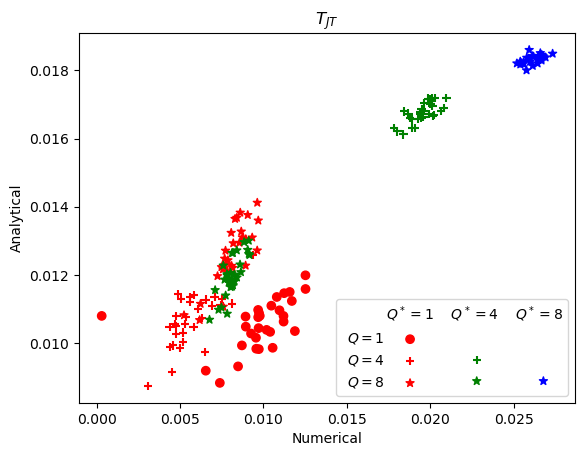

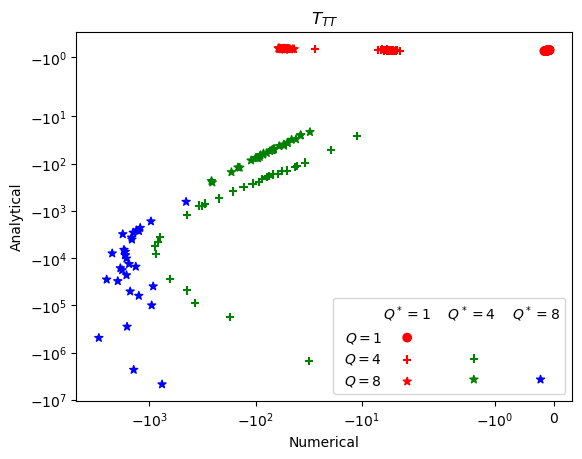

In [101]:
fig,ax=plt.subplots()
fig2,ax2=plt.subplots()

hs = np.empty((3,3),dtype=object)
cs = ['r','g','b']
ms = ['o','+','*']

Qs = [1,4,8]
for Qi,Q in enumerate(Qs):
    for Qti, Qt in enumerate(Qs):
        if Qt>Q:
            h = plt.scatter([],[],s=0)
            hs[Qti][Qi] = h
            continue
        D = np.load('run_A=BWp_P=50_S=30_N=10_Q='+str(Q)+'_Qt='+str(Qt)+'.npz',allow_pickle=True)
        allEa = D['Eanals']
        allEn = D['Enums']
        allEf = D['Efuns']
        allsea = D['seanals']
        allsen = D['senums']
        Tymin_approx = D['Ty']
        try:
            Ttt_approx = D['Ttt_approx'] #np.zeros_like(Tymin_approx)#
        except:
            print(Q,Qt)
            stop
        by_approx = D['by']
        pars = D['pars']
        Bs = D['Bz']
        Wy = pars[-1]
        bs = pars[-3]
        its=pars[-2]

        Tn = (allEn[:,0]-np.min(allEn,axis=1))/allEn[:,0]
        Ttt_n = (allEn[:,0]-allEn[:,-1])/allEn[:,0]
        bmin_n = np.argmin(allEn,axis=1)
        which = (bmin_n<bs.size-1)&(bmin_n>0)&(by_approx<bs[-1])&(by_approx>bs[0])        
        plt.figure(fig)
#         h = plt.scatter(Tn[which],Tymin_approx[which],c=[cs[Qti]]*np.sum(which),s=[2*Q]*np.sum(which),cmap=cmap)
        h = plt.scatter(Tn[which],Tymin_approx[which],c=[cs[Qti]]*np.sum(which),marker=ms[Qi])
        hs[Qti][Qi] = h
        plt.figure(fig2)

        plt.scatter(Ttt_n[which],Ttt_approx[which],c=[cs[Qti]]*np.sum(which),marker=ms[Qi])
        plt.xscale('symlog')
        plt.yscale('symlog')
        
labels = ['$Q=$'+str(Q) for Q in Qs]+['']*(len(Qs)-1)*len(Qs)
title = ' '*10+(' '*4).join(['$Q^*=$'+str(Q) for Q in Qs])

for i in range(2):
    plt.figure([fig,fig2][i])
    plt.title(['$T_{JT}$','$T_{TT}$'][i])
    plt.legend(np.ravel(hs),labels,ncol=3,markerfirst=False,title=title,loc='lower right')
    plt.xlabel('Numerical')
    plt.ylabel('Analytical')
    plt.savefig(savepath+'/2ll_num_vs_anal_'+['tjt','ttt'][i])
    

Extra plots not in paper, showing the different approximations for relative improvement over response-training as a function of $\beta$ for several different (random) hypothesized computations.

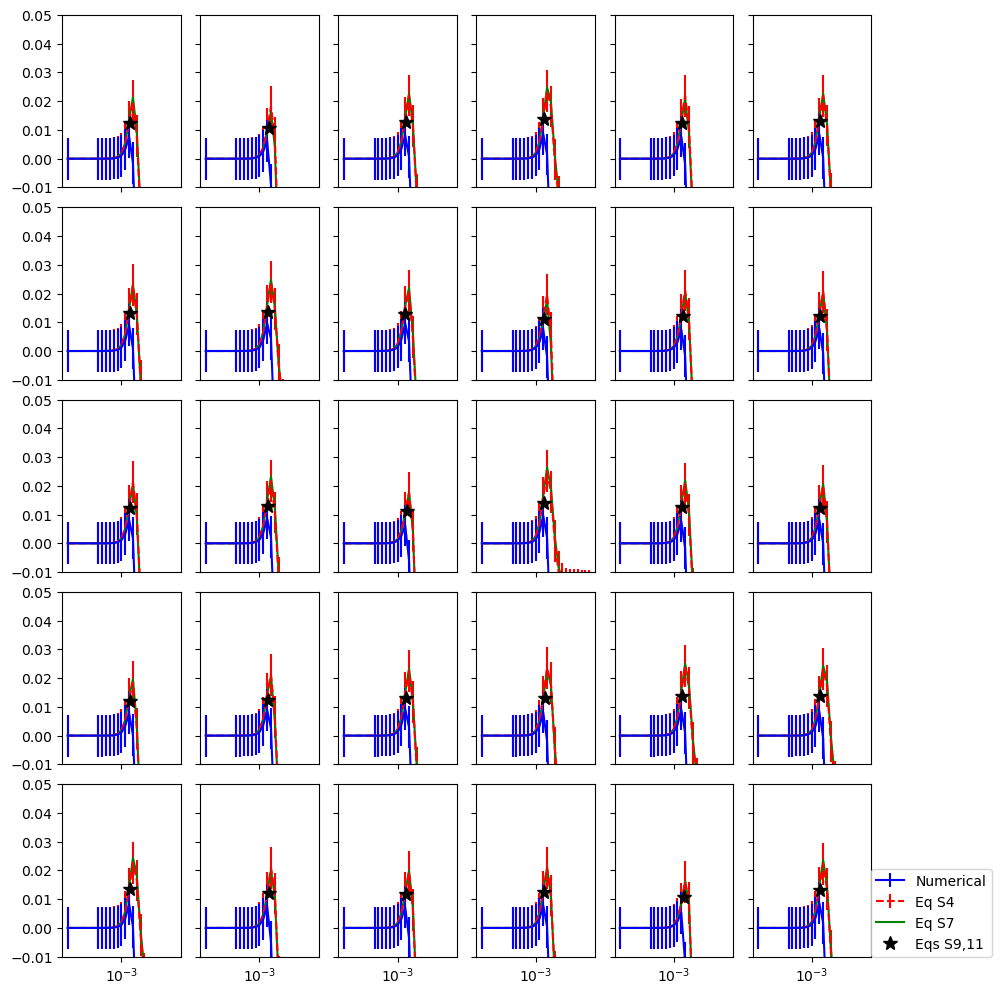

In [68]:
Q=8
Qt=1

D = np.load('run_A=BWp_P=50_S=30_N=10_Q='+str(Q)+'_Qt='+str(Qt)+'.npz',allow_pickle=True)
allEa = D['Eanals']
allEn = D['Enums']
allEf = D['Efuns']
allsea = D['seanals']
allsen = D['senums']
Tymin_approx = D['Ty']
by_approx = D['by']
pars = D['pars']
Bs = D['Bz']
Wy = pars[-1]
bs = pars[-3]
its=pars[-2]

npars=30 #number of different hypothesized computations to make plots for
fig,ax = plt.subplots(5,6,sharex=True,sharey=True,figsize=(10,10))
for i in range(npars):
    h3=ax[i//6,i%6].errorbar(bs+1e-10,(allEf[i,0]-allEf[i,:])/allEf[i,0],fmt='g')
    h2=ax[i//6,i%6].errorbar(bs*1+1e-10,(allEa[i,0]-allEa[i,:])/allEa[i,0],yerr=allsen[i,0]/allEa[i,0]/np.sqrt(its),fmt='r--')
    h1=ax[i//6,i%6].errorbar(bs+1e-10,(allEn[i,0]-allEn[i,:])/allEn[i,0],yerr=allsea[i,0]/allEn[i,0]/np.sqrt(its),fmt='b')   
    h4=ax[i//6,i%6].errorbar(by_approx[i],Tymin_approx[i],fmt='k*',markersize=10)

plt.xscale('log')
plt.ylim([-0.01,0.05])
# plt.ylim([-20,0.025])
plt.legend([h1,h2,h3,h4],['Numerical','Eq S4','Eq S7','Eqs S9,11'],loc=(1,0))
# plt.xlim([1e-10,1e-3])
fig.tight_layout()

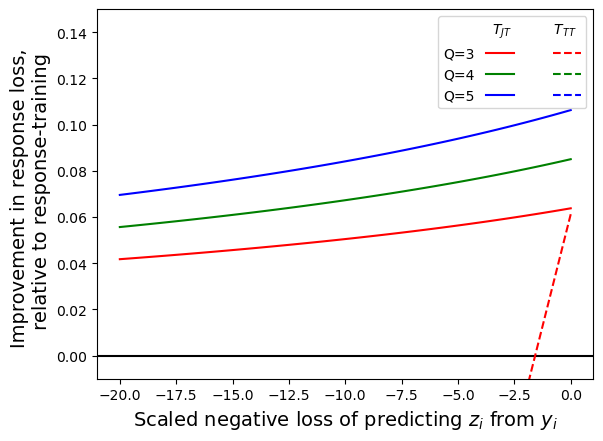

In [27]:

# analytica T_JT eq 11
Qs = [3,4,5]
cs = {Qs[0]:'r',Qs[1]:'g',Qs[2]:'b'}
le = np.linspace(0,0.2,50)
lA = 5
sx=10
sy=1
sz=3
P=50
S=30
N=6
hs = [None]*2*len(Qs)
for Qi,Q in enumerate(Qs):
    by = sy**2*(Q*lA)/(3*sy**2*(Q*lA**2)+sz**2*(Q*lA)+(P-S-1)/S*sx**2*(Q*le*lA))
    # analytica T_JT eq 11
    Tjt = sy**2*(Q*lA)**2*S/(N*(P-1))/(3*sy**2*(Q*lA**2)+sz**2*(Q*lA)+(P-S-1)/S*sx**2*(Q*le*lA))
    # analytical T_TT eq 13
    Ttt = S/(P-1) * ( 1-sz**2*(Q/lA)/(N*sy**2) ) - (P-S-1)/(P-1) * sx**2/(N*sy**2) * (Q*le/lA)
    hs[Qi]=plt.errorbar(-le*sx**2,Tjt,fmt=cs[Q])
    hs[Qi+len(Qs)]=plt.errorbar(-le*sx**2,Ttt,fmt=cs[Q]+'--')
#     plt.plot(le*sx**2,(by),'k')
title = '          $T_{JT}$          $T_{TT}$'
plt.legend(hs,np.hstack((['Q='+str(Q) for Q in Qs],['']*len(Qs))),ncol=2,markerfirst=False,title=title)
plt.ylim([-0.01,0.15])
plt.axhline(0,c='k')
# plt.grid()
plt.ylabel('Improvement in response loss, \n relative to response-training',fontsize=14)
plt.xlabel('Scaled negative loss of predicting $z_i$ from $y_i$',fontsize=14)
fig.tight_layout()
plt.savefig(savepath+'/anal_TJT_TTT_plots_zoomed.png')

Y-shaped model

In [348]:
os.chdir('../YL_summaries')

[[183   0]
 [ 96  46]]
0 (325, 200)
(325,) (325,) (325,)
0.4369230769230769 0.9292307692307692


Text(0, 0.5, 'Fraction of trials')

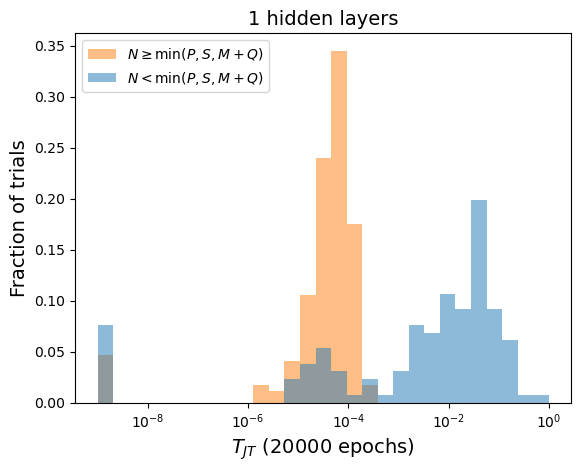

In [636]:
from sklearn.metrics import confusion_matrix
L=1
D = np.load('YL_sum_varySNMQ_L='+str(L)+'.npz')
epochs = D['epochs']
i = -1
min_Ns = np.min(D['Ns'],axis=-1) if L>1 else D['Ns']
ibnk = min_Ns<np.squeeze(np.min([D['Ps'],D['Ss'],D['Ms']+D['Qs']],axis=0))
ibnk2 = min_Ns<np.min([D['dimss'][:,0,0],np.sum(D['out_dimss'],axis=1)],axis=0)
print(confusion_matrix(ibnk,ibnk2))

T_JTs = (D['Cval_inds'][:,i]-D['Cval_JTs'][:,i])/D['Cval_inds'][:,i]+1e-9
# T_JTs = D['Cval_JTs'][:,i]
print(np.sum(D['Cval_inds'][:,0]==0),D['Cval_inds'].shape)
ok = np.squeeze(D['Ps']>D['Ss'])
print(ibnk.shape,T_JTs.shape,ok.shape)
print(np.mean(ibnk),np.mean(ok))

plt.hist([T_JTs[ibnk&ok],T_JTs[~ibnk&ok]],histtype='stepfilled',label=['$N<\min(P,S,M+Q)$','$N\geq\min(P,S,M+Q)$'],bins=np.logspace(-9,0,30),weights = [[1/np.sum(ibnk&ok)]*np.sum(ibnk&ok), [1/np.sum(~ibnk&ok)]*np.sum(~ibnk&ok)],alpha=0.5)
plt.xscale('log')
plt.legend(loc='upper left')
# print(np.mean(~ibnk&(D['Ms']<=D['Ns'])))

plt.title(str(L)+' hidden layers',fontsize=14)
plt.xlabel('$T_{JT}$ ('+str(epochs[i])+' epochs)',fontsize=14)
plt.ylabel('Fraction of trials',fontsize=14)


In [332]:
[ print(k,D[k][ibnk&(T_JTs<1e-8)]) for k in D.keys() if D[k].size==324]

Ps [45. 37. 41. 50. 49. 45.]
Ss [24. 13. 21. 37. 23. 25.]
Ns [15. 10. 19. 21. 10. 19.]
Ms [ 6. 12. 16. 17. 12. 11.]
Qs [13.  6. 15. 10. 18. 11.]


[None, None, None, None, None]

Text(0.5, 0, 'Epochs')

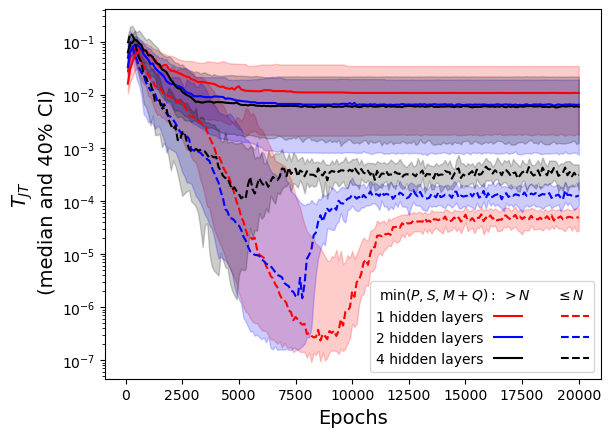

In [637]:
fig,ax = plt.subplots()
Ls = [1,2,4]
color = {1:'r',2:'b',4:'k'}
dash = ['-','--']
alpha = 0.3
plt.yscale('log')
# plt.xscale('log')
hs = [None]*len(Ls)*2

for Li,L in enumerate(Ls):
    D = np.load('YL_sum_varySNMQ_L='+str(L)+'.npz')
    min_Ns = np.min(D['Ns'],axis=-1) if len(D['Ns'].shape)==2 else D['Ns']
    ibnk = min_Ns<np.min([D['Ps'],D['Ss'],D['Ms']+D['Qs']],axis=0)
#     ibnk = min_Ns<np.min([D['dimss'][:,0,0],np.sum(D['out_dimss'],axis=1)],axis=0)
    T_JTs = (D['Cval_inds']-D['Cval_JTs'])/D['Cval_inds']+1e-9
#     T_JTs = D['Cval_JTs']
#     ok = D['Ps']>=0*np.maximum(D['Ss'],D['Ms']+D['Qs'])
    ok = D['Ps']>D['Ss']

    center = np.median(T_JTs[ibnk&ok,:],axis=0)
    yerr = np.array([np.percentile(T_JTs[ibnk&ok,:],100*alpha,axis=0),np.percentile(T_JTs[ibnk&ok,:],100*(1-alpha),axis=0)])
    hs[Li] = plt.errorbar(D['epochs'],center,fmt=color[L]+dash[0])
    plt.fill_between(D['epochs'],yerr[0,:],yerr[1,:],alpha=0.2,color=color[L])
    center = np.median(T_JTs[~ibnk&ok,:],axis=0)
    yerr = np.array([np.percentile(T_JTs[~ibnk&ok,:],100*alpha,axis=0),np.percentile(T_JTs[~ibnk&ok,:],100*(1-alpha),axis=0)])
    hs[Li+len(Ls)] = plt.errorbar(D['epochs'],center,fmt=color[L]+dash[1])
    plt.fill_between(D['epochs'],yerr[0,:],yerr[1,:],alpha=0.2,color=color[L])
    
plt.legend(hs,[str(L)+' hidden layers' for L in Ls]+['']*len(Ls),ncol = 2, title = '$\min(P,S,M+Q):$ $>N$      $\leq N$ ',markerfirst=False)#,loc='lower right')
plt.ylabel('$T_{JT}$ \n (median and '+str(int(np.round((1-2*alpha)*100)))+'% CI)',fontsize=14)
# plt.ylabel('Joint-training validation loss \n (median and '+str(int(np.round((1-2*alpha)*100)))+'% CI)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)

    

(325, 200)
(325, 200)
(325, 200)


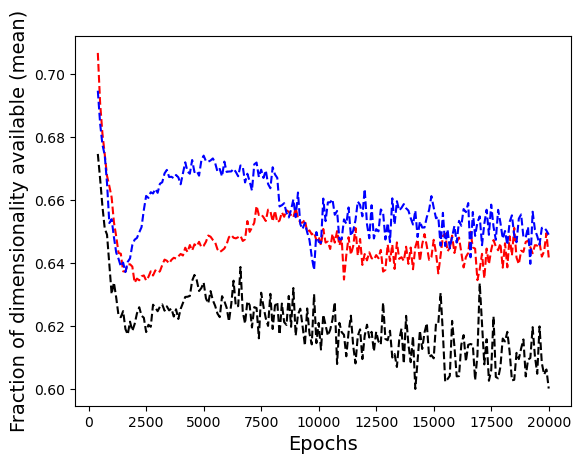

In [732]:
fig,ax = plt.subplots()
Ls = [1,2,4]
color = {1:'r',2:'b',4:'k'}
dash = ['-','--']
alpha = 0.3
# plt.yscale('log')
# plt.xscale('log')
hs = [None]*len(Ls)*2
si = 3

for Li,L in enumerate(Ls):
#     fig,ax = plt.subplots()
    D = np.load('YL_sum_varySNMQ_L='+str(L)+'.npz')
    a = np.expand_dims(np.min(D['Ns'],axis=1) if L>1 else D['Ns'],axis=-1)
    b = D['dimss'][:,:,-3]
    excess_dim = (a-b)/a
    excess_dim_ib = excess_dim[ibnk&ok,:]+np.median(excess_dim[ibnk&ok,-1:])-excess_dim[ibnk&ok,-1:]
    excess_dim_nb = excess_dim[~ibnk&ok,:]+np.median(excess_dim[~ibnk&ok,-1:])-excess_dim[~ibnk&ok,-1:]


    print(excess_dim.shape)
    ibnk = min_Ns<np.min([D['Ps'],D['Ss'],D['Ms']+D['Qs']],axis=0)
    T_JTs = (D['Cval_inds']-D['Cval_JTs'])/D['Cval_inds']+1e-9
    ok = D['Ps']>D['Ss']
#     center = np.mean(excess_dim_ib,axis=0)
#     yerr = np.array([np.percentile(excess_dim_ib,100*alpha,axis=0),np.percentile(excess_dim_ib,100*(1-alpha),axis=0)])
#     hs[Li] = plt.errorbar(D['epochs'][si:],center[si:],fmt=color[L]+dash[0])
# #     plt.fill_between(D['epochs'][si:],yerr[0,si:],yerr[1,si:],alpha=0.2,color=color[L])
    center = np.mean(excess_dim_nb,axis=0)
    yerr = np.array([np.percentile(excess_dim_nb,100*alpha,axis=0),np.percentile(excess_dim_nb,100*(1-alpha),axis=0)])
    hs[Li+len(Ls)] = plt.errorbar(D['epochs'][si:],center[si:],fmt=color[L]+dash[1])
#     plt.fill_between(D['epochs'][si:],yerr[0,si:],yerr[1,si:],alpha=0.2,color=color[L])
    
#     plt.legend(['$\min(P,S,M+Q)>N$','$\min(P,S,M+Q)\leq N$'],markerfirst=False)#,loc='lower right')
    plt.ylabel('Fraction of dimensionality available (mean)',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
# plt.ylim([0,0.05])
# plt.ylim([-0.5,1])

    

0.0
0.0
0.0


Text(0.5, 0, 'Epochs')

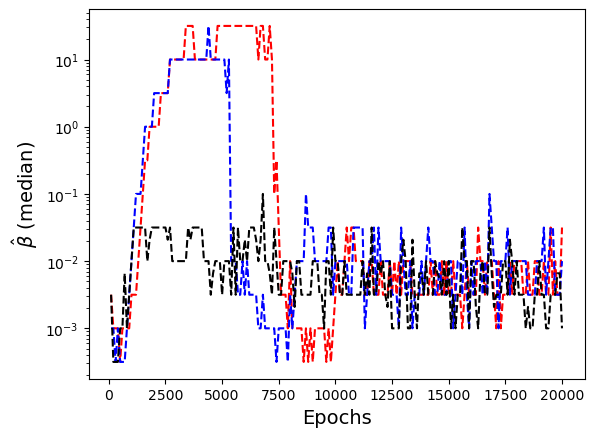

In [668]:
fig,ax = plt.subplots()
Ls = [1,2,4]
color = {1:'r',2:'b',4:'k'}
dash = ['-','--']
alpha = 0.3
plt.yscale('log')
# plt.xscale('log')
hs = [None]*len(Ls)*2
betas = np.hstack((0,np.logspace(-5,2,15)))

for Li,L in enumerate(Ls):
    D = np.load('YL_sum_varySNMQ_L='+str(L)+'.npz')
    min_Ns = np.min(D['Ns'],axis=-1) if len(D['Ns'].shape)==2 else D['Ns']
    ibnk = min_Ns<np.min([D['Ps'],D['Ss'],D['Ms']+D['Qs']],axis=0)
    T_JTs = (D['Cval_inds']-D['Cval_JTs'])/D['Cval_inds']+1e-9
    bis = D['bstaris'].astype(int)
    ok = D['Ps']>D['Ss']
    var = np.take(betas,bis,0)
    print(np.min(var))
#     center = np.median(var[ibnk&ok,:],axis=0)
#     yerr = np.array([np.percentile(var[ibnk&ok,:],100*alpha,axis=0),np.percentile(var[ibnk&ok,:],100*(1-alpha),axis=0)])
#     hs[Li] = plt.errorbar(D['epochs'],center,fmt=color[L]+dash[0])
# #     plt.fill_between(D['epochs'],yerr[0,:],yerr[1,:],alpha=0.2,color=color[L])
    center = np.median(var[~ibnk&ok,:],axis=0)
    yerr = np.array([np.percentile(var[~ibnk&ok,:],100*alpha,axis=0),np.percentile(var[~ibnk&ok,:],100*(1-alpha),axis=0)])
    hs[Li+len(Ls)] = plt.errorbar(D['epochs'],center,fmt=color[L]+dash[1])
#     plt.fill_between(D['epochs'],yerr[0,:],yerr[1,:],alpha=0.2,color=color[L])
    
# plt.legend(hs,[str(L)+' hidden layers' for L in Ls]+['']*len(Ls),ncol = 2, title = '$\min(P,S,M+Q):$ $>N$      $\leq N$ ',markerfirst=False)#,loc='lower right')
plt.ylabel(r'$\hat\beta$ (median)',fontsize=14)
# plt.ylabel('Joint-training validation loss \n (median and '+str(int(np.round((1-2*alpha)*100)))+'% CI)',fontsize=14)
plt.xlabel('Epochs',fontsize=14)

    

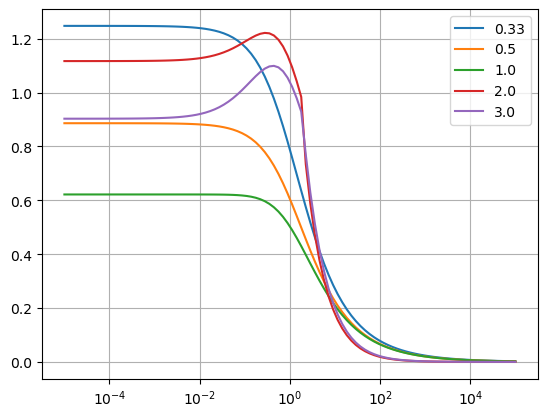

In [734]:
b = np.logspace(-5,5,100)
a = b/(1+b)
c = np.array([1/3,0.5,1,2,3])
s1 = np.array([(1+0.2*np.random.normal())*(1-a)*(1+np.sqrt(1+4*a/(1-a)*ci))/2 for ci in c])
s2 = np.array([(1+0.2*np.random.normal())*(1-a)*2/(1-(1-a)/a/ci)+np.where(2/(ci+1)<a,0,np.nan) for ci in c])
# s2 = np.array([(1+0*np.random.normal())*(1-a)*(1+a/(1-a)*ci) for ci in c])

if True:
    plt.plot(a/(1-a),np.nanmin([s1,s2],axis=0).T)
else:
    plt.plot(a/(1-a),s1.T)
    plt.gca().set_prop_cycle(None)
    plt.plot(a/(1-a),s2.T,'--')
# plt.ylim([0,2])
plt.legend(np.round(c,2))
plt.xscale('log')
plt.grid()
# plt.yscale('log')

In [ ]:
b = np.logspace(-2,2,100)
a = b/(1+b)
c = np.array([0.2,1/3,0.5,1,2,3,5])
s1 = np.array([ for ci in c])

plt.plot(a/(1-a),s1.T)
plt.ylim([0,2])
# plt.ylim([0,2])
plt.legend(np.round(c,2))
plt.xscale('log')
# plt.yscale('log')

(325, 200)


NameError: name 'stop' is not defined

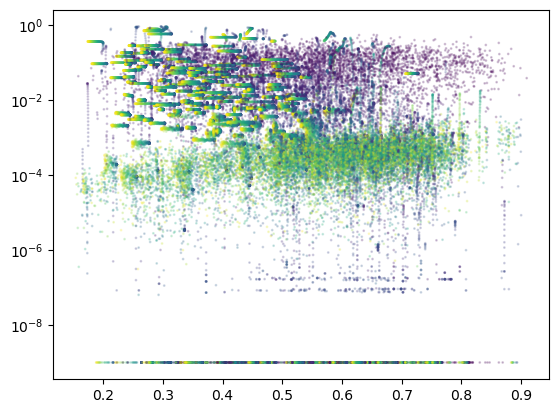

In [578]:
fig,ax = plt.subplots()
Ls = [4,1,2,4]
color = {1:'r',2:'b',4:'k'}
dash = ['-','--']
alpha = 0.3
plt.yscale('log')
# plt.xscale('log')
hs = [None]*len(Ls)*2

for Li,L in enumerate(Ls):
    D = np.load('YL_sum_varySNMQ_L='+str(L)+'.npz')
    a = np.expand_dims(np.min(D['Ns'],axis=1) if L>1 else D['Ns'],axis=-1)
    b = D['dimss'][:,:,-3]
    excess_dim = (a-b)/a
    print(excess_dim.shape)
    ibnk = min_Ns<np.min([D['Ps'],D['Ss'],D['Ms']+D['Qs']],axis=0)
    T_JTs = (D['Cval_inds']-D['Cval_JTs'])/D['Cval_inds']+1e-9
    ok = D['Ps']>D['Ss']

    for ind in range(T_JTs.shape[0]):
#         plt.plot(excess_dim[ind,:],T_JTs[ind,:],'k',alpha=0.01)
        plt.scatter(excess_dim[ind,:],T_JTs[ind,:],c=np.arange(T_JTs.shape[1]),alpha=0.2,s=1)
    stop
    
# plt.legend(hs,[str(L)+' hidden layers' for L in Ls]+['']*len(Ls),ncol = 2, title = '$\min(P,S,M+Q):$ $>N$      $\leq N$ ',markerfirst=False)#,loc='lower right')
plt.ylabel('$T_{JT}$',fontsize=14)
plt.xlabel('Relative excess dimensionality',fontsize=14)

    